In [35]:
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from datetime import datetime
from pylab import rcParams
import statsmodels.api as sm
import itertools
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [36]:
#Reading dataset
dataset = pd.read_csv('salesdaily_pharma_datatoread.csv')
dataset

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Total sales,Year,Month,Hour,Weekday Name
0,1/2/2014,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,48.470,2014,1,248,Thursday
1,1/3/2014,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,107.000,2014,1,276,Friday
2,1/4/2014,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,91.350,2014,1,276,Saturday
3,1/5/2014,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,66.100,2014,1,276,Sunday
4,1/6/2014,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,58.200,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,52.723,2019,10,276,Friday
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,47.580,2019,10,276,Saturday
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,67.490,2019,10,276,Sunday
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,82.647,2019,10,276,Monday


In [37]:
#DATA PREPROCESSING 
#convert string Date time into Python Date time object
dataset['datum'] = pd.to_datetime(dataset['datum'])
#removing unwanted columns
to_drop = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name'] #removing unwanted columns
dataset.drop(columns=to_drop, inplace=True)
print(dataset.info()) # to check for empty values
dataset = dataset.groupby('datum')['Total sales'].sum().reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datum        2106 non-null   datetime64[ns]
 1   Total sales  2106 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.0 KB
None


In [38]:
#Indexing with Time Series Data
dataset = dataset.set_index('datum')
dataset.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11',
               ...
               '2019-09-29', '2019-09-30', '2019-10-01', '2019-10-02',
               '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06',
               '2019-10-07', '2019-10-08'],
              dtype='datetime64[ns]', name='datum', length=2106, freq=None)

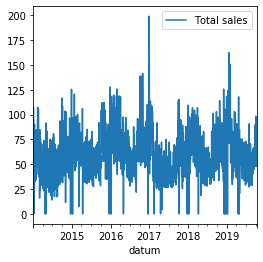

In [39]:
#Plotting the original data
dataset.plot()
plt.show()

In [40]:
#Removing outliers using interquartile range 
Q1 = dataset["Total sales"].quantile(0.25) #calculating quantiles to know what are the outliers
print (Q1)
Q3 = dataset["Total sales"].quantile(0.75)
print (Q3)
IQR = Q3 - Q1
lower =  Q1 - 1.5 * IQR # the lower and upper bounds for data based on outliers
upper = Q3 + 1.5 * IQR
dataset = dataset[(dataset["Total sales"] < upper) & (dataset["Total sales"]> lower)]

46.446749999999994
72.81425


(array([], dtype=int64),)


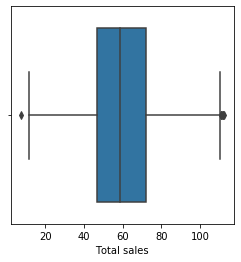

In [41]:
#Box plot to see if outiers are removed
sns.boxplot(dataset['Total sales'])
#data points for z>3 are removed
z = np.abs(stats.zscore(dataset['Total sales']))
threshold = 3
print(np.where(z > 3))

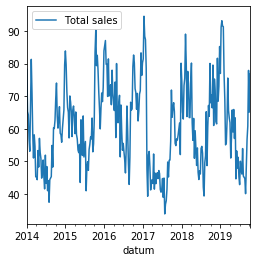

In [42]:
#Data smoothing
#using average daily sales value for the month since individual values cause huge variations
dataset = dataset.resample('W').mean()
dataset.plot()
plt.show()

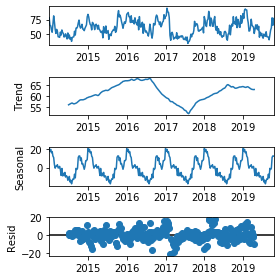

In [43]:
#ARIMA- to model using ARIMA, it is important to see what kind of trend, seasonality exists in data
#time series decomposition to see trend, seasonality and noise
rcParams['figure.figsize'] = 4,4  
decomposition = sm.tsa.seasonal_decompose(dataset, model='additive')
fig = decomposition.plot()
plt.show()

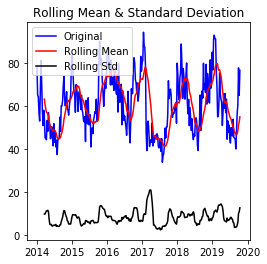

In [44]:
#Testing stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(dataset) 
# mean and standard deviation are almost constant

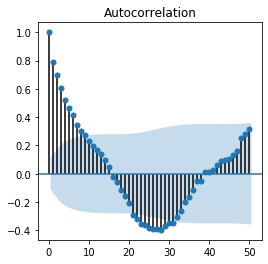

In [45]:
#Deciding parameters of ARIMA. Looking at acf we decide to use p =2 and q=0 as #if there is a Positive autocorrelation at lag 1 then we use the AR model, 
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf 
plot_acf(dataset, lags=50)
pyplot.show()

In [46]:
#To deicde d for ARIMA we make a null hypothesis of the ADF test is that the time series is non-stationary. 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(dataset.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# As p > 0.05 (slightly greater), we decide to make data sttaionary

ADF Statistic: -4.506018
p-value: 0.000192


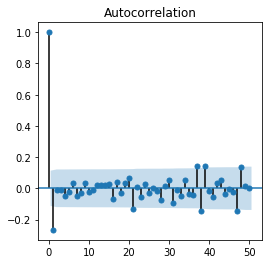

In [47]:
#from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf #if there is If there is a Positive autocorrelation at lag 1 then we use the AR model
dataset.diff().dropna()
plot_acf(dataset.diff().dropna(), lags=50)
pyplot.show()

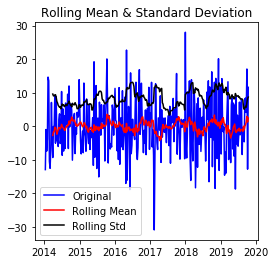

In [48]:
test_stationarity(dataset.diff().dropna()) #very constant mean and std deviation as compared original data
#p=2, d=1 and q=0

                             ARIMA Model Results                              
Dep. Variable:          D.Total sales   No. Observations:                  301
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1053.723
Method:                       css-mle   S.D. of innovations              8.018
Date:                Mon, 11 May 2020   AIC                           2115.446
Time:                        23:21:19   BIC                           2130.274
Sample:                    01-12-2014   HQIC                          2121.380
                         - 10-13-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0009      0.336     -0.003      0.998      -0.659       0.657
ar.L1.D.Total sales    -0.2923      0.058     -5.066      0.000      -0.405      -0.179
ar.L2.D.Total sa

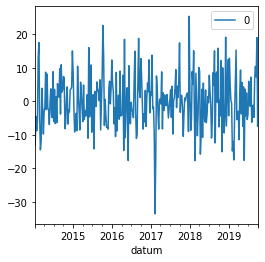

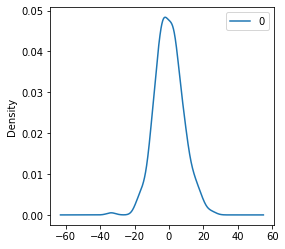

                0
count  301.000000
mean    -0.015512
std      8.033826
min    -33.533767
25%     -5.143163
50%     -0.294176
75%      4.851389
max     25.339242


In [49]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

model = ARIMA(dataset, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())
# The line plot of the residual errors, suggesting that there may still be some trend information not captured by the model
#The mean of data is centered almost around zero, which says there is no significant bias mean   -0.024510

predicted=67.422557, expected=65.362571
predicted=65.788153, expected=55.565571
predicted=57.800247, expected=54.860857
predicted=55.523538, expected=56.914429
predicted=56.390544, expected=56.588286
predicted=56.405127, expected=58.053000
predicted=57.642325, expected=60.025143
predicted=59.397702, expected=61.808000
predicted=61.202027, expected=52.115000
predicted=53.998272, expected=80.134000
predicted=74.031900, expected=74.658200
predicted=74.065920, expected=65.207143
predicted=67.908651, expected=63.010571
predicted=64.254059, expected=73.306714
predicted=71.019521, expected=75.535000
predicted=74.067590, expected=89.052143
predicted=85.829217, expected=79.912857
predicted=81.023736, expected=63.757857
predicted=68.283573, expected=77.621571
predicted=75.978829, expected=73.804000
predicted=73.297421, expected=63.474000
predicted=66.354608, expected=63.465429
predicted=64.551187, expected=74.413429
predicted=71.750698, expected=80.179333
predicted=77.560530, expected=61.834000


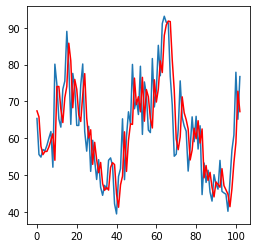

In [50]:
#Predicting using ARIMA for p=2, q=0 and d=1
X = dataset.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()